<a href="https://colab.research.google.com/github/jrakhshanda/Deep-Learning/blob/master/trafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

In [1]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"rakhshandajabeen55","key":"2483f350dd73f648b655ddd3456c3ce1"}
import json
import zipfile
import os
!chmod 600 /root
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c sweden-traffic-signs-classification
os.chdir('/content/')

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
  0% 0.00/3.54M [00:00<?, ?B/s]
100% 3.54M/3.54M [00:00<00:00, 58.2MB/s]
  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 228MB/s]
  0% 0.00/81.9k [00:00<?, ?B/s]
100% 81.9k/81.9k [00:00<00:00, 73.0MB/s]
  0% 0.00/16.7k [00:00<?, ?B/s]
100% 16.7k/16.7k [00:00<00:00, 15.2MB/s]
  0% 0.00/3.40M [00:00<?, ?B/s]
100% 3.40M/3.40M [00:00<00:00, 232MB/s]
  0% 0.00/11.9k [00:00<?, ?B/s]
100% 11.9k/11.9k [00:00<00:00, 10.8MB/s]


In [2]:
from zipfile import ZipFile
with ZipFile('/content/data.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/data.zip' mode='r'>


In [3]:
import pandas as pd
import numpy as np
import keras
from tensorflow.keras import activations

from keras.models import Sequential
from keras.layers import  Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import random
from matplotlib import pyplot as plt
from matplotlib import cm

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

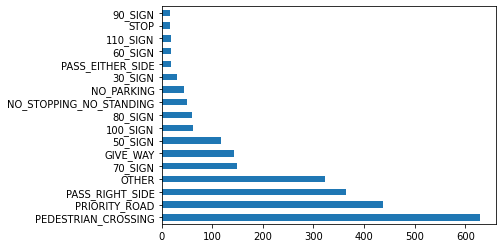

In [5]:
train["label"].value_counts().plot(kind = "barh")

In [6]:
train, validate = train_test_split(train, test_size=0.30, random_state=20)

In [139]:
im_size = (60,60)
b_size = 200
train_datagen = ImageDataGenerator(
    #rotation_range=15,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
)
train_generator = train_datagen.flow_from_dataframe(
    train, 
    "/content/data/data", 
    x_col='file_name',
    y_col='label',
    target_size=im_size,
    class_mode='categorical',
    batch_size=b_size
)

Found 1752 validated image filenames belonging to 17 classes.


In [140]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate, 
    "/content/data/data/", 
    x_col='file_name',
    y_col='label',
    target_size=im_size,
    class_mode='categorical',
    batch_size=b_size
)

Found 751 validated image filenames belonging to 17 classes.


In [141]:
def createModel( num_classes,image_shape):
  model = Sequential()

  model.add(Conv2D(16,kernel_size=(5,5),activation= "relu",input_shape = image_shape, strides=(2,2)))
  model.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),activation= "relu"))
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),activation= "relu"))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(512,activation= 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(learning_rate= 0.001),metrics = ['accuracy'])

  return model
batch_size = b_size
num_classes = 17
image_shape = (60,60,3)
model = createModel(num_classes,image_shape)

In [142]:
#keras.utils.plot_model(model,show_shapes= True,show_layer_names=True)


In [143]:
earlyStop = EarlyStopping(patience = 20)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.001)

In [144]:
epochs = 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[earlyStop,variable_gradient]
)

Epoch 1/50
9/9 [==============================] - 1s 106ms/step - loss: 2.8170 - accuracy: 0.2352 - val_loss: 2.0062 - val_accuracy: 0.3529
Epoch 2/50
9/9 [==============================] - 1s 81ms/step - loss: 1.9012 - accuracy: 0.4041 - val_loss: 1.9808 - val_accuracy: 0.2650
Epoch 3/50
9/9 [==============================] - 1s 82ms/step - loss: 1.5373 - accuracy: 0.5371 - val_loss: 1.6084 - val_accuracy: 0.5459
Epoch 4/50
9/9 [==============================] - 1s 78ms/step - loss: 1.1506 - accuracy: 0.6655 - val_loss: 0.8616 - val_accuracy: 0.7989
Epoch 5/50
9/9 [==============================] - 1s 80ms/step - loss: 1.1485 - accuracy: 0.6644 - val_loss: 0.8607 - val_accuracy: 0.7670
Epoch 6/50
9/9 [==============================] - 1s 80ms/step - loss: 0.7640 - accuracy: 0.7991 - val_loss: 0.6900 - val_accuracy: 0.8189
Epoch 7/50
9/9 [==============================] - 1s 81ms/step - loss: 0.7125 - accuracy: 0.8065 - val_loss: 0.6355 - val_accuracy: 0.8375
Epoch 8/50
9/9 [==========

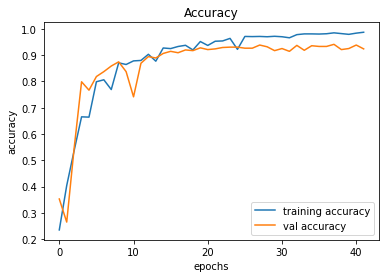

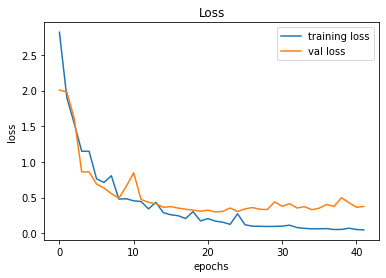

In [145]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [138]:
validation_generator.reset()
predIdxs = model.predict_generator(validation_generator)
predIdxsClasses = np.argmax(predIdxs, axis=1)
print(classification_report(validation_generator.classes, predIdxsClasses,
    target_names=validation_generator.class_indices))

                         precision    recall  f1-score   support

               100_SIGN       0.00      0.00      0.00        20
               110_SIGN       0.00      0.00      0.00         4
                30_SIGN       0.02      0.15      0.03        13
                50_SIGN       0.00      0.00      0.00        37
                60_SIGN       0.00      0.00      0.00         2
                70_SIGN       0.00      0.00      0.00        50
                80_SIGN       0.03      0.79      0.07        24
                90_SIGN       0.00      0.00      0.00         3
               GIVE_WAY       0.00      0.00      0.00        44
             NO_PARKING       0.00      0.00      0.00        14
NO_STOPPING_NO_STANDING       0.00      0.00      0.00        17
                  OTHER       0.00      0.00      0.00        96
       PASS_EITHER_SIDE       0.00      0.00      0.00         6
        PASS_RIGHT_SIDE       0.00      0.00      0.00       113
    PEDESTRIAN_CROSSING 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


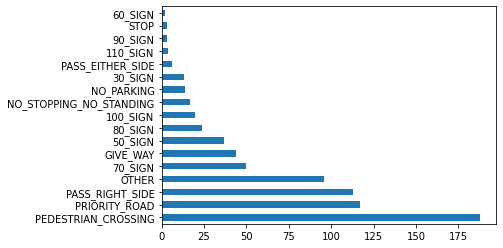

In [100]:
validate["label"].value_counts().plot(kind = "barh")

In [ ]:
test.head()

,file_name
0,picture-176290.jpg
1,picture-834444.jpg
2,picture-768882.jpg
3,picture-212331.jpg
4,picture-277367.jpg


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test, 
    "/content/data/data/", 
    x_col='file_name',
    y_col=None,
    target_size=(70,70),
    class_mode=None,
    batch_size=32
)

Found 610 validated image filenames.


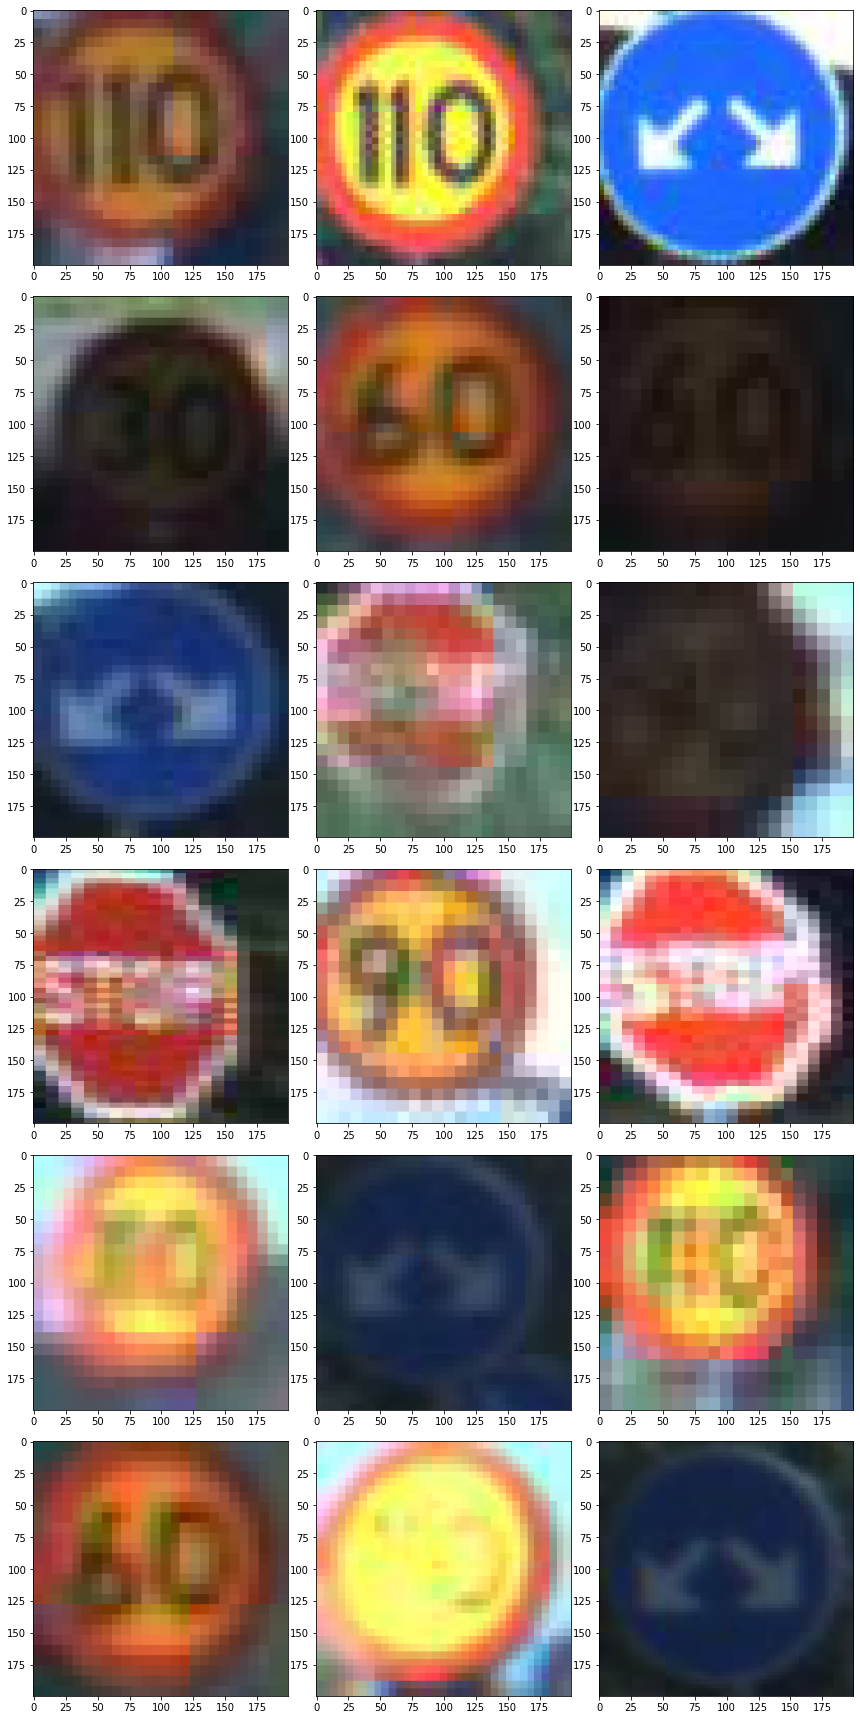

In [ ]:
sample_test = test.head(18)
sample_test.head()
pyplot.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['file_name']
    img = load_img("/content/data/data/"+filename, target_size=(200,200))
    pyplot.subplot(6, 3, index+1)
    pyplot.imshow(img)
pyplot.tight_layout()
pyplot.show()